# Generate Training Data
## Preparation

In [1]:
from scapy.all import *
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
import logging

logging.basicConfig(level=logging.DEBUG)

In [3]:
# Formatters for displaying pandas data tables with columns of (lists of) scapy packets

def packet_list_fmt(lst):
    return f"{len(lst)} packets"

def packet_fmt(pkt):
    return pkt[DNS].summary()

In [4]:
# retrieve information encoded in DNS qnames

def split_qname(row):
    qname = row['qname']
    parts = qname.split(b".")
    try:
        if b".".join(parts[-3:]) == b"dnstb.net.":
            zone_parts = parts[-4].split(b"-")
            resolver_parts = parts[-5].split(b"-")
            return {
                'zone_algorithm': zone_parts[0],
                'zone_keysize': zone_parts[1],
                'zone_nsec': zone_parts[2],
                'zone_status': zone_parts[3],
                'resolver': resolver_parts[2],
            }
    except IndexError:
        logging.warning(f"could not split qname {qname} into meaningful information")
        return {
            'zone_algorithm': None,
            'zone_keysize': None,
            'zone_nsec': None,
            'zone_status': None,
            'resolver': None,
        }
    return None

## Load Data

In [5]:
%%bash 

mkdir -p ../traffic
rsync -aP root@ns1.dnstb.net:/var/log/tcplogger/ ../traffic/

receiving incremental file list
./
br-62c9071a079d-20210611220858.pcap
      2,267,834 100%   28.46MB/s    0:00:00 (xfr#1, to-chk=52/64)
eth0-20210611220858.pcap
        596,195 100%    6.93MB/s    0:00:00 (xfr#2, to-chk=34/64)
veth0fa1ef7-20210611220858.pcap
      2,267,336 100%   20.40MB/s    0:00:00 (xfr#3, to-chk=15/64)
vethcfdfec4-20210611220858.pcap
      1,709,579 100%   13.70MB/s    0:00:00 (xfr#4, to-chk=3/64)


In [6]:
# load the traffic logs
# TODO: loop over available traffic dumps

c_logs = filter(lambda s: s, """tcpdump_lab_dev_vpn0_bind9113_20210610190354.pcap
tcpdump_lab_dev_vpn0_cloudflare_20210610192648.pcap
tcpdump_lab_dev_vpn0_comodo-secure-dns_20210610192648.pcap
tcpdump_lab_dev_vpn0_cznic-odvr_20210610192648.pcap
tcpdump_lab_dev_vpn0_freenom-world_20210610192648.pcap
tcpdump_lab_dev_vpn0_google_20210610192648.pcap
tcpdump_lab_dev_vpn0_kresd532_20210610190354.pcap
tcpdump_lab_dev_vpn0_neustar-free-recursive_20210610192648.pcap
tcpdump_lab_dev_vpn0_norton-connectsafe_20210610192648.pcap
tcpdump_lab_dev_vpn0_opennic_20210610192648.pcap
tcpdump_lab_dev_vpn0_oracle-dyn_20210610192648.pcap
tcpdump_lab_dev_vpn0_powerdns460_20210610190354.pcap
tcpdump_lab_dev_vpn0_quad9_20210610192648.pcap
tcpdump_lab_dev_vpn0_unbound167_20210610190354.pcap
tcpdump_lab_dev_vpn0_ws2012_20210610190354.pcap
tcpdump_lab_dev_vpn0_ws2012r2_20210610190354.pcap
tcpdump_lab_dev_vpn0_ws2016_20210610190354.pcap
tcpdump_lab_dev_vpn0_ws2019_20210610190354.pcap
""".split("\n"))

c_packets = reduce(lambda a,b: a + b, (rdpcap(f"../traffic/{f}") for f in c_logs))
if not 's_packets' in globals().keys():
    s_packets = rdpcap('../traffic/eth0-20210607084941.pcap')

In [7]:
# using the client logs, get a list of queries

queries = []
queries_by_id = {}

for p in c_packets:
    if p[DNS].qr == 0:
        # query
        qid = p[DNS].id
        q = {
            'id': qid,
            'qname': p[DNS].qd.qname,
            'tag': p[DNS].qd.qname.split(b'.', 1)[0],
            'started': p.time,
            'client_packets': [p],
            'server_packets': [],
        }
        queries.append(q)
        queries_by_id[qid] = q
    else:
        # response
        qid = p[DNS].id
        queries_by_id[qid]['finished'] = p.time
        queries_by_id[qid]['client_packets'].append(p)
    
queries = pd.DataFrame(queries)
queries.style.format({'server_packets': packet_list_fmt, 'client_packets': packet_list_fmt})
queries['qname_parts'] = queries.apply(split_qname, axis=1)
for key in ['zone_algorithm', 'zone_keysize', 'zone_nsec', 'zone_status', 'resolver']:
    queries[key] = queries.apply(lambda row: row['qname_parts'][key], axis=1)
del queries['qname_parts']

first_query_time, last_query_time = queries['started'].min(), queries['finished'].max()

## Match Client and Server Data

In [8]:
# filter server packets to relevant times

s_packets = s_packets.filter(lambda p: first_query_time <= p.time <= last_query_time)

In [10]:
# using the server logs, match packets captured at the server to the client's questions

candidates = []

for p in tqdm(s_packets):
    if queries['started'].min() <= p.time <= queries['finished'].max():
        try:
            p_dns = tag = p[DNS]
        except IndexError:
            logging.warning(f'packet with timestamp {p.time} could not be parsed as DNS packet')
        
        tag = p_dns.qd.qname.split(b'.', 1)[0]
        candidate_queries = (queries['started'] <= p.time) & (p.time <= queries['finished']) & (queries['tag'] == tag)
        if sum(candidate_queries) == 0:
            continue
        elif sum(candidate_queries) == 1:
            queries[candidate_queries].iloc[0]['server_packets'].append(p)
        else:
            logging.warning(f'Initial DNS query not uniquely identified for packet with time stamp {p.time}')
        

100%|██████████| 25298/25298 [00:53<00:00, 470.00it/s]


## Clean and Organize Data

In [11]:
# drop rows that do not have exactly two client packets

queries['num_client_packets'] = queries.apply(lambda row: len(row['client_packets']), axis=1)
drop = queries['num_client_packets'] != 2
if sum(drop):
    logging.warning(f'Dropping {sum(drop)} of {len(queries)} queries as they do not have exactly two client packets')
    for count, num in zip(*np.unique(queries['num_client_packets'], return_counts=True)):
        if count == 2: continue
        logging.warning(f'- {num} queries had {count} client packet(s)')
queries = queries.drop(queries[drop].index)

queries['client_query'] = queries.apply(lambda row: row['client_packets'][0], axis=1)
queries['client_response'] = queries.apply(lambda row: row['client_packets'][1], axis=1)
del queries['client_packets']

In [12]:
queries['client_response_rcode'] = queries.apply(lambda row: row['client_response'].rcode, axis=1)

In [13]:
# TODO: select server packet(s) for feature extraction

def take_first_query(packet_list):
    queries = filter(lambda p: p[DNS].qr == 0, packet_list)
    try:
        return next(iter(queries))
    except StopIteration:
        return None

queries['server_query'] = queries.apply(lambda row: take_first_query(row['server_packets']), axis=1)

In [14]:
drop = queries['server_query'].isnull()
if sum(drop):
    logging.warning(f"Dropping {sum(drop)} of {len(queries)} queries as corresponding server packets could not be found!")
    queries = queries.drop(queries[drop].index)

## Extract Features and Label

In [15]:
# set the label

queries['label_rcode'] = queries['client_response_rcode']
queries['label_resolver'] = queries['resolver']

In [16]:
# set some features

queries['feature_ip_ttl'] = queries.apply(lambda row: row['server_query'][IP].ttl, axis=1)
queries['feature_ip_src'] = queries.apply(lambda row: row['server_query'][IP].src, axis=1)
queries['feature_ip_proto'] = queries.apply(lambda row: row['server_query'][IP].proto, axis=1)
queries['feature_udp_len'] = queries.apply(lambda row: row['server_query'][UDP].len, axis=1)
queries['feature_dns_qr'] = queries.apply(lambda row: row['server_query'][DNS].qr, axis=1)
queries['feature_dns_opcode'] = queries.apply(lambda row: row['server_query'][DNS].opcode, axis=1)
queries['feature_dns_aa'] = queries.apply(lambda row: row['server_query'][DNS].aa, axis=1)
queries['feature_dns_tc'] = queries.apply(lambda row: row['server_query'][DNS].tc, axis=1)
queries['feature_dns_rd'] = queries.apply(lambda row: row['server_query'][DNS].rd, axis=1)
queries['feature_dns_ra'] = queries.apply(lambda row: row['server_query'][DNS].ra, axis=1)
queries['feature_dns_z'] = queries.apply(lambda row: row['server_query'][DNS].z, axis=1)
queries['feature_dns_cd'] = queries.apply(lambda row: row['server_query'][DNS].cd, axis=1)
queries['feature_dns_rcode'] = queries.apply(lambda row: row['server_query'][DNS].rcode, axis=1)
queries['feature_dns_qdcount'] = queries.apply(lambda row: row['server_query'][DNS].qdcount, axis=1)
queries['feature_dns_ancount'] = queries.apply(lambda row: row['server_query'][DNS].ancount, axis=1)
queries['feature_dns_nscount'] = queries.apply(lambda row: row['server_query'][DNS].nscount, axis=1)
queries['feature_dns_arcount'] = queries.apply(lambda row: row['server_query'][DNS].arcount, axis=1)
queries['feature_zone_algorithm'] = queries['zone_algorithm']
queries['feature_zone_keysize'] = queries['zone_keysize']
queries['feature_zone_nsec'] = queries['zone_nsec']

## Show Data
### All Columns

In [17]:
queries.iloc[-10:].style.format({'server_packets': packet_list_fmt, 'client_query': packet_fmt, 'client_response': packet_fmt, 'server_query': packet_fmt})

,id,qname,tag,started,server_packets,finished,zone_algorithm,zone_keysize,zone_nsec,zone_status,resolver,num_client_packets,client_query,client_response,client_response_rcode,server_query,label_rcode,label_resolver,feature_ip_ttl,feature_ip_src,feature_ip_proto,feature_udp_len,feature_dns_qr,feature_dns_opcode,feature_dns_aa,feature_dns_tc,feature_dns_rd,feature_dns_ra,feature_dns_z,feature_dns_cd,feature_dns_rcode,feature_dns_qdcount,feature_dns_ancount,feature_dns_nscount,feature_dns_arcount
2120,50782,b'lab-dev-ws2019-20210610190354.rsasha512-2048-1-signedok.dnstb.net.',b'lab-dev-ws2019-20210610190354',1623344757.312459,4 packets,1623344757.386533,b'rsasha512',b'2048',b'1',b'signedok',b'ws2019',2,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-2048-1-signedok.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-2048-1-signedok.dnstb.net.'""",0,b'ws2019',115,141.12.128.13,17,102,0,0,0,0,0,0,0,1,0,1,0,0,1
2121,28069,b'lab-dev-ws2019-20210610190354.rsasha512-2048-3-signedbrokennods.dnstb.net.',b'lab-dev-ws2019-20210610190354',1623344757.391466,4 packets,1623344757.481043,b'rsasha512',b'2048',b'3',b'signedbrokennods',b'ws2019',2,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-2048-3-signedbrokennods.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-2048-3-signedbrokennods.dnstb.net.'""",0,b'ws2019',115,141.12.128.13,17,110,0,0,0,0,0,0,0,1,0,1,0,0,1
2122,28896,b'lab-dev-ws2019-20210610190354.rsasha512-2048-3-signedbrokenwrongds.dnstb.net.',b'lab-dev-ws2019-20210610190354',1623344757.483925,4 packets,1623344757.555211,b'rsasha512',b'2048',b'3',b'signedbrokenwrongds',b'ws2019',2,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-2048-3-signedbrokenwrongds.dnstb.net.'""",DNS Ans,2,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-2048-3-signedbrokenwrongds.dnstb.net.'""",2,b'ws2019',115,141.12.128.13,17,113,0,0,0,0,0,0,0,1,0,1,0,0,1
2123,30951,b'lab-dev-ws2019-20210610190354.rsasha512-2048-3-signedok.dnstb.net.',b'lab-dev-ws2019-20210610190354',1623344757.558125,4 packets,1623344757.628336,b'rsasha512',b'2048',b'3',b'signedok',b'ws2019',2,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-2048-3-signedok.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-2048-3-signedok.dnstb.net.'""",0,b'ws2019',115,141.12.128.13,17,102,0,0,0,0,0,0,0,1,0,1,0,0,1
2124,44308,b'lab-dev-ws2019-20210610190354.rsasha512-4096-1-signedbrokennods.dnstb.net.',b'lab-dev-ws2019-20210610190354',1623344757.632565,4 packets,1623344757.735813,b'rsasha512',b'4096',b'1',b'signedbrokennods',b'ws2019',2,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-4096-1-signedbrokennods.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-4096-1-signedbrokennods.dnstb.net.'""",0,b'ws2019',115,141.12.128.13,17,110,0,0,0,0,0,0,0,1,0,1,0,0,1
2125,29229,b'lab-dev-ws2019-20210610190354.rsasha512-4096-1-signedbrokenwrongds.dnstb.net.',b'lab-dev-ws2019-20210610190354',1623344757.739562,4 packets,1623344757.810859,b'rsasha512',b'4096',b'1',b'signedbrokenwrongds',b'ws2019',2,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-4096-1-signedbrokenwrongds.dnstb.net.'""",DNS Ans,2,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-4096-1-signedbrokenwrongds.dnstb.net.'""",2,b'ws2019',115,141.12.128.13,17,113,0,0,0,0,0,0,0,1,0,1,0,0,1
2126,50630,b'lab-dev-ws2019-20210610190354.rsasha512-4096-1-signedok.dnstb.net.',b'lab-dev-ws2019-20210610190354',1623344757.813906,4 packets,1623344757.887006,b'rsasha512',b'4096',b'1',b'signedok',b'ws2019',2,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-4096-1-signedok.dnstb.net.'""","DNS Ans ""8.8.8.8""",0,"DNS Qry ""b'lab-dev-ws2019-20210610190354.rsasha512-4096-1-signedok.dnstb.net.'""",0,b'ws2019',115,141.12.128.13,17,102,0,0,0,0,0,0,0,1,0,1,0,0,1
2127,15320,b'lab-dev-ws2019-20210610190354.rsasha512-4096-3-signedbrokennods.dnstb.net.',b'lab-dev-ws2019-20210610190354',

### ML Columns

In [18]:
# collect columns relevant for ML
ML = list(filter(lambda c: c.startswith('label_') or c.startswith('feature_'), queries.keys()))

In [ ]:
# collect rows relevant for ML
signedok = queries['zone_status'] == b'signedok'

In [19]:
# save table to disk
queries[signedok][ML].to_pickle('ml_data.pickle')

In [20]:
# show table
queries[signedok][ML].iloc[-10:].style.format({'server_packets': packet_list_fmt, 'client_query': packet_fmt, 'client_response': packet_fmt})

,label_rcode,label_resolver,feature_ip_ttl,feature_ip_src,feature_ip_proto,feature_udp_len,feature_dns_qr,feature_dns_opcode,feature_dns_aa,feature_dns_tc,feature_dns_rd,feature_dns_ra,feature_dns_z,feature_dns_cd,feature_dns_rcode,feature_dns_qdcount,feature_dns_ancount,feature_dns_nscount,feature_dns_arcount
2120,0,b'ws2019',115,141.12.128.13,17,102,0,0,0,0,0,0,0,1,0,1,0,0,1
2121,0,b'ws2019',115,141.12.128.13,17,110,0,0,0,0,0,0,0,1,0,1,0,0,1
2122,2,b'ws2019',115,141.12.128.13,17,113,0,0,0,0,0,0,0,1,0,1,0,0,1
2123,0,b'ws2019',115,141.12.128.13,17,102,0,0,0,0,0,0,0,1,0,1,0,0,1
2124,0,b'ws2019',115,141.12.128.13,17,110,0,0,0,0,0,0,0,1,0,1,0,0,1
2125,2,b'ws2019',115,141.12.128.13,17,113,0,0,0,0,0,0,0,1,0,1,0,0,1
2126,0,b'ws2019',115,141.12.128.13,17,102,0,0,0,0,0,0,0,1,0,1,0,0,1
2127,0,b'ws2019',115,141.12.128.13,17,110,0,0,0,0,0,0,0,1,0,1,0,0,1
2128,2,b'ws2019',115,141.12.128.13,17,113,0,0,0,0,0,0,0,1,0,1,0,0,1
2129,0,b'ws2019',115,141.12.128.13,17,102,0,0,0,0,0,0,0,1,0,1,0,0,1


In [21]:
sum(signedok)

1726

### Some Data Insights

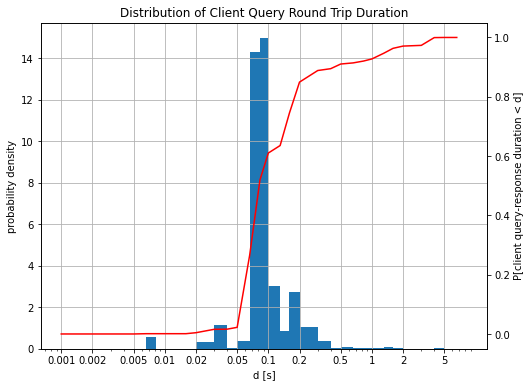

In [138]:
# client query duration distribution

queries['duration'] = queries['finished'] - queries['started']

data = queries['duration'].astype(np.float).dropna()
bins = [b*10**p for p in [-3, -2, -1, 0] for b in [1,1.3,1.6,2,3,4,5,6.6,8.3]]
labels = bins[::3]
hist, bin_edges = np.histogram(data, bins=bins)
cdf = np.cumsum(hist)

plt.figure(figsize=(8, 6))
plt.grid(True)

ax, tax = plt.gca(), plt.twinx()

ax.hist(data, bins=bins, density=True)
ax.set_ylabel('probability density')
ax.set_xlabel('d [s]')

tax.plot(bin_edges[:-1], cdf/cdf[-1], c='r')
tax.set_ylabel('P[client query-response duration < d]')

plt.xscale('log')
plt.xticks(labels, map(str, labels))
plt.title('Distribution of Client Query Round Trip Duration')

None

In [23]:
# show a single query to the server

for p in queries.iloc[200]['server_packets']:
    if p[DNS].qr != 0:
        continue
    print(p[IP].show())

###[ IP ]### 
  version   = 4
  ihl       = 5
  tos       = 0x0
  len       = 126
  id        = 23622
  flags     = DF
  frag      = 0
  ttl       = 57
  proto     = udp
  chksum    = 0x8685
  src       = 162.158.83.30
  dst       = 130.149.230.81
  \options   \
###[ UDP ]### 
     sport     = 9716
     dport     = domain
     len       = 106
     chksum    = 0xffcf
###[ DNS ]### 
        id        = 59161
        qr        = 0
        opcode    = QUERY
        aa        = 0
        tc        = 0
        rd        = 0
        ra        = 0
        z         = 0
        ad        = 0
        cd        = 0
        rcode     = ok
        qdcount   = 1
        ancount   = 0
        nscount   = 0
        arcount   = 1
        \qd        \
         |###[ DNS Question Record ]### 
         |  qname     = 'lab-dev-cloudflare-20210610192648.rsasha256-4096-1-signedok.dnstb.net.'
         |  qtype     = A
         |  qclass    = IN
        an        = None
        ns        = None
        \ar    

In [24]:
# show response code grouped by zone status, resolver, algorithm, key size, nsec

pd.options.display.max_rows = None
queries.groupby(['zone_status', 'resolver', 'zone_algorithm', 'zone_keysize', 'zone_nsec']).agg({
    'client_response_rcode': ['min', 'mean', 'max']
})

client_response_rcode  \
                                                                                                   min   
zone_status            resolver       zone_algorithm      zone_keysize zone_nsec                         
b'signedbrokennods'    b'bind9113'    b'ecdsap256sha256'  b'256'       b'1'                          0   
                                                                       b'3'                          0   
                                      b'ecdsap384sha384'  b'384'       b'1'                          0   
                                                                       b'3'                          0   
                                      b'ed25519'          b'256'       b'1'                          0   
                                                                       b'3'                          0   
                                      b'ed448'            b'456'       b'1'                          0   
                                                                       b'3'                          0   
                                      b'rsasha1'          b'1024'      b'1'                          0   
                                                                       b'3'                          0   
                                                          b'1871'      b'1'                          0   
                                                                       b'3'                          0   
                                                          b'2048'      b'1'                          0   
                                                                       b'3'                          0   
                                                          b'4096'      b'1'                          0   
                                                                       b'3'                          0   
                                      b'rsasha1nsec3sha1' b'1024'      b'1'                          0   
                                                                       b'3'                          0   
                                                          b'1871'      b'1'                          0   
                                                                       b'3'                          0   
                                                          b'2048'      b'1'                          0   
                                                                       b'3'                          0   
                                                          b'4096'      b'1'                          0   
                                                                       b'3'                          0   
                                      b'rsasha256'        b'1024'      b'1'                          0   
                                                                       b'3'                          0   
                                                          b'1871'      b'1'                          0   
                                                                       b'3'                          0   
                                                          b'2048'      b'1'                          0   
                                                                       b'3'                          0   
                                                          b'4096'      b'1'                          0   
                                                                       b'3'                          0   
                                      b'rsasha512'        b'1024'      b'1'                          0   
                                                                       b'3'                          0   
                                                          b'1871'      b'1'                          0   
                                                     